## Краткая формулировка задачи: необходимо спрогнозировать количество продаж для некоторых товаров для трех недель в 2015 году. Известны продажи товаров до этого.

## После длительного рассматривания данных можно заметить, что для каждого товара каждую неделю признаки сдвигаются на один влево. Последний признак появляется и по нему можно почти однозначно найти количество продаж в ту неделю, для который этот признак настоящий (week - shift). Почти однозначно, так как константа, на которую нужно домножить признак немного варируется. Для нескольких товаров отличается прилично. Поэтому для всех недель, кроме последней можно дать результат с хорошей точностью. Для предсказания последней недели можно предсказать, какой новый признак появится справа на следующей неделе. Для этого я преобразовал данные так: собрал в одной строке для одного товара все появляющиеся признаки по очереди. Затем "прошелся" по этой строке окном длинной 52, записывая 52 значения в train выборку, а ответом к ней служил 53-ий признак. Тестовая выборка состоит из последних 52 значений и предсказывая ответ на ней, мы угадываем, какой признак появится на следующей неделе. На этих данных я обучал XGBoost, где менял параметры, улучшая результат.

## Больше всего помогла регулировка параметров модели из ансамблей деревьев. Если не использовать дефолтные параметры, то можно улучшить результат в разы. Пробовал убирать столбцы из исходной таблицы train, результат становился хуже, несмотря на то, что из 60 столбцов 30 повторяются со вторыми 30.

## Кроссвалидацию делал рандомную, так как поменял структуру данных и зависимость их от времени не давала бы более оптимистичный результат

In [131]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn import datasets, cross_validation, metrics, neighbors
from matplotlib.colors import ListedColormap
from pandas import DataFrame
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [132]:
import pandas as pd
import xgboost


train = pd.read_csv("train.tsv")
test = pd.read_csv("test.tsv")
sample_submission = pd.read_csv("sample_submission.tsv")

In [133]:
train_items = list(train['item_id'])
test_items = list(test['item_id'])
dif_train_items = dict(zip(train_items, train_items)).values()
dif_test_items = dict(zip(test_items, test_items)).values()
dif_train_items = list(dif_train_items)
dif_test_items = list(dif_test_items)
print(len(dif_train_items))
print(len(dif_test_items))
x_we_need = []
for i in range(len(dif_train_items)):
    if (dif_train_items[i] not in dif_test_items):
        x_we_need.append(dif_train_items[i])
X_1 = train.values
X_train_2 = []
for i in range(len(X_1)):
    if (X_1[i][5] in dif_test_items):
        X_train_2.append(X_1[i])
print(len(train), len(X_train_2))

286
227
72457 66255


In [134]:
test = test.values
train = train.values
sort_item = []
for name in dif_test_items:
    for i in range(len(test)):
        if test[i][4] == name:
            sort_item.append(test[i])

In [135]:
sort_train_item = []
for name in dif_test_items:
    for i in range(len(train)):
        if train[i][5] == name and train[i][4] == 1:
            sort_train_item.append(train[i])

In [136]:
magic_coef = []
for i in range(1, len(sort_train_item)):
    if(sort_train_item[i][5] == sort_train_item[i - 1][5]):
        magic_coef.append((sort_train_item[i][5], sort_train_item[i - 1][1] / sort_train_item[i][65]))
coef = np.median(magic_coef)

In [137]:
magic_dif_coefs = []
for item in range(len(dif_test_items)):
    coefs = []
    for i in range(len(magic_coef)):
        if(dif_test_items[item] == magic_coef[i][0]):
            coefs.append(magic_coef[i][1])
    magic_dif_coefs.append((dif_test_items[item], coefs))

In [138]:
need_coefs = []
for item in range(len(dif_test_items)):
    need_coefs.append((dif_test_items[item], np.median(magic_dif_coefs[item][1])))
    print(dif_test_items[item], np.median(magic_dif_coefs[item][1]))

20449792 1.6099659181
20443307 1.60994475138
20442117 1.60997830803
20438536 1.60999281093
20438537 1.60999225407
20438538 1.60999927812
20438539 1.60999916313
20438540 1.60999908127
20453393 1.60998347278
20453396 1.60999396742
20438691 1.6
20451161 1.6099378882
20438703 1.60999917102
20449309 1.60998796631
20441124 1.60999745009
20448805 1.60999428334
20452902 1.60999031344
20450856 1.60999495086
20442153 1.60997271414
20450858 1.60996610169
20438571 1.60999962802
20438572 1.60999697832
20438583 1.60999412738
20448312 1.60952380952
20441951 1.60998197699
20449342 1.60999291769
20438591 1.60994764398
20449345 1.60998356797
20449347 1.60992907801
20442693 1.6099997211
20442694 1.60999770629
20441953 1.60980392157
20438601 1.60975609756
20438602 1.60996168582
20438603 1.60999463295
20438604 1.60987370838
20449357 1.60999186065
20449358 1.60999253786
20438607 1.60999475576
20449360 1.60999547647
20438609 1.60999746009
20442194 1.60997647828
20438611 1.60998658233
20439124 1.6
20442200 1.

In [139]:
answers = []
for i in range(len(sort_item)):
    for j in range(len(need_coefs)):
        if (need_coefs[j][0] == sort_item[i][4]):
            answers.append((sort_item[i][0], sort_item[i][1], sort_item[i][2] - sort_item[i][3], sort_item[i][4],
                    round(need_coefs[j][1]*sort_item[i][64])))
for i in range(len(answers)):
    answers[i] = list(answers[i])
for i in range(len(answers)):
    if (answers[i][2] == 0):
        answers[i][1] = 2014
        answers[i][2] = 53

In [140]:
y = [0.0 for i in range(2016)]
for i in range(len(y)):
    for j in range(len(answers)):
        if ((test[i][1] == answers[j][1]) and (test[i][2] == answers[j][2]) and (test[i][4] == answers[j][3])):
            y[i] = answers[j][4]

In [141]:
for i in range(len(y)):
    for j in range(len(train)):
        if ((test[i][1] == train[j][2]) and (test[i][2] == train[j][3]) and (test[i][4] == train[j][5])):
            y[i] = train[j][1]

In [142]:
sort_train_item = pd.DataFrame(sort_train_item)
sort_train_item

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,260117,354,2014,25,1,20449792,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,263472,3912,2014,26,1,20449792,0,0,0,0,...,0,0,0,0,0,0,0,0,0,220
2,266825,7486,2014,27,1,20449792,0,0,0,0,...,0,0,0,0,0,0,0,0,220,2430
3,270187,13878,2014,28,1,20449792,0,0,0,0,...,0,0,0,0,0,0,0,220,2430,4650
4,273549,11390,2014,29,1,20449792,0,0,0,0,...,0,0,0,0,0,0,220,2430,4650,8620
5,276919,16433,2014,30,1,20449792,0,0,0,0,...,0,0,0,0,0,220,2430,4650,8620,7075
6,280300,16431,2014,31,1,20449792,0,0,0,0,...,0,0,0,0,220,2430,4650,8620,7075,10207
7,283684,7038,2014,32,1,20449792,0,0,0,0,...,0,0,0,220,2430,4650,8620,7075,10207,10206
8,287078,27386,2014,33,1,20449792,0,0,0,0,...,0,0,220,2430,4650,8620,7075,10207,10206,4372
9,290480,33568,2014,34,1,20449792,0,0,0,0,...,0,220,2430,4650,8620,7075,10207,10206,4372,17010


In [143]:
sort_train_item = sort_train_item.values

In [144]:
coef

20427028.0

In [145]:
sort_train_item[28][8]

220.0

In [146]:
3860/2398

1.609674728940784

In [147]:
y = pd.DataFrame(y)
y

,0
0,1497
1,27033
2,297560
3,29471
4,16
5,146242
6,67735
7,111941
8,102631
9,3542


In [148]:
print (y[y[0] == 0])

      0
455   0
607   0
608   0
625   0
626   0
653   0
654   0
907   0
1059  0
1060  0
1077  0
1078  0
1105  0
1106  0
1130  0
1131  0
1132  0
1133  0
1134  0
1135  0
1136  0
1137  0
1138  0
1139  0
1140  0
1141  0
1142  0
1143  0
1144  0
1145  0
...  ..
1986  0
1987  0
1988  0
1989  0
1990  0
1991  0
1992  0
1993  0
1994  0
1995  0
1996  0
1997  0
1998  0
1999  0
2000  0
2001  0
2002  0
2003  0
2004  0
2005  0
2006  0
2007  0
2008  0
2009  0
2010  0
2011  0
2012  0
2013  0
2014  0
2015  0

[681 rows x 1 columns]


In [149]:
answers = pd.DataFrame(answers)
answers

,0,1,2,3,4
0,348707,2014,53,20449792,45226
1,349604,2015,1,20449792,12054
2,349845,2015,1,20449792,12054
3,350276,2015,2,20449792,22644
4,350517,2015,2,20449792,22644
5,350738,2015,2,20449792,22644
6,350963,2015,3,20449792,27419
7,351184,2015,3,20449792,27419
8,351404,2015,4,20449792,50229
9,348632,2014,53,20443307,2294


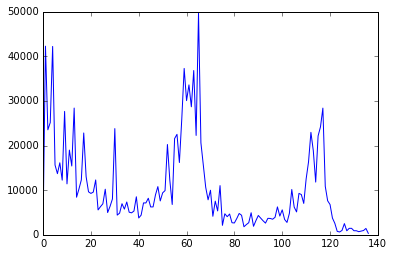

In [150]:
k = [0.0,220.0,2430.0,4650.0,8620.0,7075.0,10207.0,10206.0,4372.0,17010.0,20850.0,6810.0,13880.0,10628.0,12562.0,3420.0,
2386.0,2433.0,3758.0,20206.0,17062.0,19578.0,19987.0,24967.0,19470.0,11992.0,32363.0,17943.0,27913.0,28091.0,7487.0, 14065.0,
        17031.0,31199.0]
z = [1981.0,42254.0,23520.0,25145.0,42198.0,15635.0,13700.0,16130.0,12243.0,27643.0,11410.0,18978.0,15412.0,28390.0,
 8420.0,10270.0,12305.0,22810.0,13021.0,9632.0,9270.0,9570.0,12290.0,5570.0,6301.0,6950.0,10210.0,4985.0,6358.0,
 8023.0,23792.0,4410.0,4855.0,6970.0,5752.0,7345.0,5060.0,4920.0,5320.0,8516.0,3770.0,4400.0,7140.0,7136.0,
 8190.0,6241.0,6250.0,8940.0,10797.0,7590.0,9399.0,9900.0,20230.0,12220.0,6790.0,21560.0,22510.0,16190.0,
 25935.0,37270.0,30060.0,33580.0,28680.0,36800.0,22260.0,49647.0,20610.0,15750.0,10668.0,7840.0,9980.0,
 4150.0,7540.0,5350.0,11020.0,2120.0,4710.0,4060.0,4650.0,2700.0,2650.0,3650.0,4780.0,4380.0,1800.0,
 2290.0,2708.0,4940.0,1900.0,3180.0,4330.0,3740.0,3140.0,2620.0,3690.0,3660.0,3492.0,3920.0,6250.0,
 4190.0,5592.0,3438.0,2770.0,4810.0,10150.0,6210.0,5120.0,9280.0,9015.0,7030.0,12500.0,16330.0,22947.0,
 18830.0,11810.0,22140.0,24180.0,28380.0,10860.0,7620.0,6780.0,3750.0,2570.0,770.0,630.0,980.0,2511.0,900.0,
 1450.0,1450.0,914.0,910.0,700.0,820.0,958.0,1425.0,322.0]
p = np.linspace(0, 136, 137)
p_2 = np.linspace(0, len(k) - 1, len(k))
pyplot.plot(p, z)

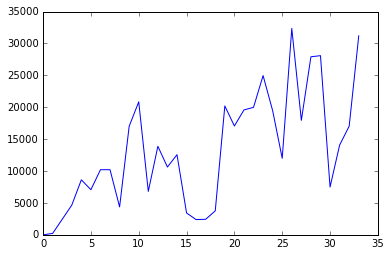

In [151]:
pyplot.plot(p_2, k)

In [152]:
full_features = []
for name in dif_test_items:
    str_in_full = []
    for i in range(len(train)):
        if ((train[i][5] == name) and ((name, train[i][65], train[i][2], train[i][3]) not in str_in_full) 
            and (name, train[i][2], train[i][3]) not in [(str_in_full[g][0], str_in_full[g][2], str_in_full[g][3]) 
                                                       for g in range(len(str_in_full))]):
            str_in_full.append((name, train[i][65], train[i][2], train[i][3]))
    for i in range(len(test)):
        if ((test[i][4] == name) and ((name, test[i][64], test[i][1], test[i][2]) not in str_in_full) 
            and (name, test[i][1], test[i][2]) not in [(str_in_full[g][0], str_in_full[g][2], str_in_full[g][3]) 
                                                       for g in range(len(str_in_full))]):
            str_in_full.append((name, test[i][64], test[i][1], test[i][2]))
    full_features.append(str_in_full[:-1])
iterat = 0
for name in dif_test_items:
    str_in_full = []
    for i in range(len(test)):
        if(test[i][2] == 5):
            if ((test[i][4] == name) and ((name, test[i][64], test[i][1], test[i][2]) not in str_in_full)):
                str_in_full.append((name, test[i][64], test[i][1], test[i][2]))
    for h in range(len(str_in_full)):
        full_features[iterat].append(str_in_full[h])
    iterat += 1

In [153]:
full_features[8]

[(20453393, 228.0, 2012.0, 52.0),
 (20453393, 228.0, 2013.0, 1.0),
 (20453393, 228.0, 2013.0, 2.0),
 (20453393, 1176.0, 2013.0, 3.0),
 (20453393, 1000.0, 2013.0, 4.0),
 (20453393, 720.0, 2013.0, 5.0),
 (20453393, 2526.0, 2013.0, 6.0),
 (20453393, 4698.0, 2013.0, 7.0),
 (20453393, 7320.0, 2013.0, 8.0),
 (20453393, 8280.0, 2013.0, 9.0),
 (20453393, 9022.0, 2013.0, 10.0),
 (20453393, 8245.0, 2013.0, 11.0),
 (20453393, 15162.0, 2013.0, 12.0),
 (20453393, 3538.0, 2013.0, 13.0),
 (20453393, 5678.0, 2013.0, 14.0),
 (20453393, 10576.0, 2013.0, 15.0),
 (20453393, 11667.0, 2013.0, 16.0),
 (20453393, 24438.0, 2013.0, 17.0),
 (20453393, 6998.0, 2013.0, 18.0),
 (20453393, 8278.0, 2013.0, 19.0),
 (20453393, 9652.0, 2013.0, 20.0),
 (20453393, 6600.0, 2013.0, 21.0),
 (20453393, 13860.0, 2013.0, 22.0),
 (20453393, 12447.0, 2013.0, 23.0),
 (20453393, 12596.0, 2013.0, 24.0),
 (20453393, 21543.0, 2013.0, 25.0),
 (20453393, 28424.0, 2013.0, 26.0),
 (20453393, 9584.0, 2013.0, 27.0),
 (20453393, 30577.0, 201

In [154]:
len(y)

2016

In [155]:
class item:
    def __init__(self, item = 0, size = 0, features = [], first_year = 0, last_year = 2015, 
                 first_week = 0, last_week = 0, continuity = 0, pred = 0):
        self.item = item
        self.size = size
        self.features = features
        self.first_year = first_year
        self.last_year = last_year
        self.first_week = first_week
        self.last_week = last_week
        self.continuity = continuity
        self.pred = 0

In [156]:
shop = [item() for i in range(len(dif_test_items))]

113 8914.4159292 83780459.358
113 23738.5840708 91138318.2606
113 76625.6814159 3385048089.72
113 55257.8141593 1597150268.93
113 774318.699115 54385867757.8
113 601839.769912 39183968150.3
113 601535.522124 29767349060.2
113 33011.5752212 396826739.837
113 87177.1681416 1117491158.81
110 80.4545454545 6289.79338843
113 600842.451327 25009272777.8
81 27932.4691358 227340774.718
113 198940.539823 2543373754.25
92 79389.7391304 1695983162.67
113 55044.7256637 958305940.341
113 110198.955752 1836502194.17
113 17532.5221239 18261111.2761
113 15133.8672566 27913979.6372
113 1435239.76991 219702251006.0
113 136762.19469 1390686517.06
113 89585.3893805 437560326.025
104 803.125 103301.051683
113 29206.3893805 52844753.4413
113 69092.920354 694789233.241
113 8642.86725664 11067446.3629
113 31094.3716814 159581900.959
113 6711.7079646 7677278.02976
113 1476898.29204 350366982315.0
113 241964.168142 4396861980.53
113 2815.62831858 7762066.853
112 1712.39285714 545837.952806
113 11638.7699115 938

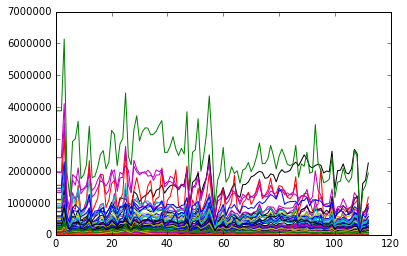

In [157]:
avrg_y = []
for i in range(len(full_features)):
    y_loc = []
    for j in range(len(full_features[i])):
        y_loc.append(full_features[i][j][1])
    shop[i].size = len(y_loc)
    shop[i].item = full_features[i][0][0]
    shop[i].features = y_loc
    shop[i].first_year = np.min([full_features[i][l][2] for l in range(len(full_features[i]))])
    shop[i].first_week = np.min([full_features[i][l][3] for l in range(len(full_features[i])) 
                                 if full_features[i][l][2] == shop[i].first_year])
    x = np.linspace(0, len(y_loc) - 1, len(y_loc))
    if len(y_loc) > 50:
        print(len(y_loc), np.mean(y_loc), np.var(y_loc))
        avrg_y.append((full_features[i][0][0], np.mean(y_loc)))
        pyplot.plot(x, y_loc)

(array([ 6.,  0.,  2.,  0.,  2.,  1.,  3.,  4.,  2.,  1.,  2.,  1.,  1.,
         2.,  0.,  1.,  0.,  0.,  0.,  2.,  1.,  1.,  0.,  2.,  2.,  4.,
         3.,  5.,  2.,  7.,  3.,  3.,  4.,  4.,  3.,  3.,  5.,  1.,  2.,
         4.,  1.,  4.,  3.,  2.,  1.,  1.,  0.,  1.,  3.,  0.,  0.,  0.,
         0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([    228.  ,    1344.74,    2461.48,    3578.22,    4694.96,
           5811.7 ,    6928.44,    8045.18,    9161.92,   10278.66,
          11395.4 ,   12512.14,   13628.88,   14745.62,   15862.36,
          16979.1 ,   18095.84,   19212.58,   20329.32,   21446.06,
          22562.8 ,   23679.54,   24796.28,   25913.02,   27029.76,
          28146.5 ,   29263.24,   30379.98,   31496.72,   32613.46,
          33730.2 ,   3484

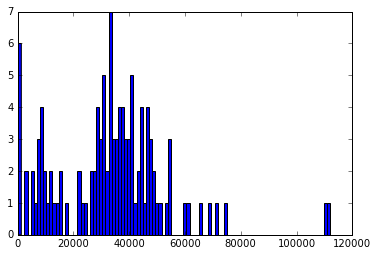

In [158]:
hist(shop[8].features, bins = 100)

In [159]:
avrg_y

[(20443307, 8914.4159292035401),
 (20442117, 23738.58407079646),
 (20438536, 76625.681415929197),
 (20438537, 55257.814159292036),
 (20438538, 774318.6991150442),
 (20438539, 601839.76991150447),
 (20438540, 601535.52212389384),
 (20453393, 33011.575221238942),
 (20453396, 87177.16814159292),
 (20438691, 80.454545454545453),
 (20438703, 600842.45132743358),
 (20449309, 27932.469135802468),
 (20441124, 198940.53982300885),
 (20448805, 79389.739130434784),
 (20452902, 55044.725663716818),
 (20450856, 110198.95575221239),
 (20442153, 17532.522123893807),
 (20450858, 15133.867256637168),
 (20438571, 1435239.7699115044),
 (20438572, 136762.19469026549),
 (20438583, 89585.389380530978),
 (20448312, 803.125),
 (20441951, 29206.389380530974),
 (20449342, 69092.920353982307),
 (20438591, 8642.8672566371679),
 (20449345, 31094.371681415931),
 (20449347, 6711.7079646017701),
 (20442693, 1476898.2920353983),
 (20442694, 241964.16814159293),
 (20441953, 2815.6283185840707),
 (20438601, 1712.3928571

In [160]:
num_of_good_values = 0
for i in range(len(shop)):
    if shop[i].size < 113:
        num_of_good_values += 1
        print(shop[i].item, shop[i].size, shop[i].first_year, shop[i].first_week)
print(num_of_good_values)

20449792 36 2014.0 25.0
20438691 110 2012.0 52.0
20451161 25 2014.0 36.0
20449309 81 2013.0 32.0
20448805 92 2013.0 21.0
20448312 104 2013.0 9.0
20438601 112 2012.0 52.0
20449357 80 2013.0 33.0
20449358 80 2013.0 33.0
20449360 72 2013.0 41.0
20442194 112 2012.0 52.0
20439124 32 2012.0 52.0
20449893 18 2014.0 43.0
20449471 58 2014.0 3.0
20427396 108 2012.0 52.0
20450441 44 2014.0 17.0
20451471 24 2014.0 37.0
20438687 108 2012.0 52.0
20438688 106 2012.0 52.0
20450246 39 2014.0 15.0
20448958 84 2013.0 29.0
20448959 85 2013.0 28.0
20451022 31 2014.0 30.0
20451023 29 2014.0 32.0
20451039 29 2014.0 32.0
20451040 28 2014.0 33.0
20449525 70 2013.0 43.0
20441131 112 2012.0 52.0
20448900 89 2013.0 24.0
20443944 106 2012.0 52.0
20449581 18 2014.0 43.0
20449584 68 2013.0 45.0
20450609 41 2014.0 20.0
20450612 32 2014.0 29.0
20451671 18 2014.0 43.0
20451673 17 2014.0 44.0
20448095 110 2013.0 3.0
20451681 16 2014.0 45.0
20448455 100 2013.0 13.0
20448162 106 2013.0 7.0
20438953 104 2012.0 52.0
2045226

In [161]:
262570 / 36006

7.292395711825807

In [162]:
for i in range(len(shop)):
    if shop[i].size == 113:
        print(shop[i].item, shop[i].features[:10])

20443307 [8023.0, 8023.0, 8023.0, 23792.0, 4410.0, 4855.0, 6970.0, 5752.0, 7345.0, 5060.0]
20442117 [32826.0, 32826.0, 32826.0, 76585.0, 14414.0, 17140.0, 30783.0, 25557.0, 50060.0, 18640.0]
20438536 [67828.0, 67828.0, 67828.0, 262570.0, 36006.0, 38140.0, 61880.0, 59540.0, 186950.0, 50030.0]
20438537 [56900.0, 56900.0, 56900.0, 194110.0, 24460.0, 29700.0, 41530.0, 43380.0, 145250.0, 29090.0]
20438538 [1379397.0, 1379397.0, 1379397.0, 1639693.0, 570928.0, 389768.0, 1319239.0, 1100001.0, 1240548.0, 723943.0]
20438539 [1072060.0, 1072060.0, 1072060.0, 1538955.0, 390422.0, 315140.0, 1107287.0, 871260.0, 1120653.0, 552481.0]
20438540 [842247.0, 842247.0, 842247.0, 1420585.0, 377587.0, 287951.0, 791739.0, 561490.0, 785722.0, 456828.0]
20453393 [228.0, 228.0, 228.0, 1176.0, 1000.0, 720.0, 2526.0, 4698.0, 7320.0, 8280.0]
20453396 [79130.0, 79130.0, 79130.0, 195491.0, 67279.0, 37201.0, 96284.0, 82980.0, 88536.0, 62910.0]
20438703 [898751.0, 898751.0, 898751.0, 1239075.0, 383617.0, 287840.0, 588

In [163]:
new_X_train = []
new_y_train = []
new_X_test = []
new_len = 52
shop_index = 1
for name in range(len(shop)):
    if shop[name].size == 113:
        for j in range(2, len(shop[name].features) - new_len - 1):
            new_X_train.append(shop[name].features[j:j+new_len])
            new_y_train.append(shop[name].features[j+new_len + 1])
        new_X_test.append(shop[name].features[-new_len:])

new_X_train_part, new_X_test_part, new_y_train_part, new_y_test_part = cross_validation.train_test_split(
    new_X_train, new_y_train, test_size=0.02, random_state=1)        

from sklearn.ensemble import GradientBoostingRegressor
model = xgboost.XGBRegressor(max_depth=29, n_estimators=549, learning_rate=1/12, reg_alpha=0.5, min_child_weight=6, 
                            reg_lambda=5, base_score = 0.3)
model.fit(new_X_train, new_y_train, eval_metric = 'mae')
preds = model.predict(new_X_test)
#print(preds)
#print(symmetric_mean_absolute_percentage_error(new_y_test_part, preds))

In [171]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor(max_depth=33, n_estimators=1000)
model.fit(new_X_train, new_y_train)
preds = model.predict(new_X_test)
#print(preds)
#print(symmetric_mean_absolute_percentage_error(new_y_test_part, preds))

In [172]:
flag = 0
for i in range(len(shop)):
    if(shop[i].size == 113):
        shop[i].pred = preds[flag]
        flag += 1

In [173]:
print(len(preds))

177


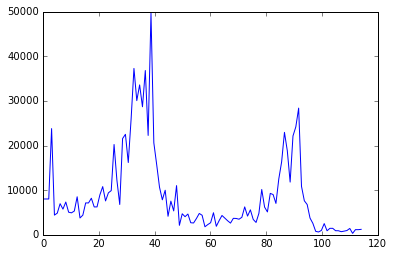

In [174]:
pyplot.plot(np.linspace(0, len(shop[1].features) + 1, len(shop[1].features)), shop[1].features)

In [176]:
y = y.values
print(len(y))
for i in range(len(y)):
    if y[i] == 0:
        for j in range(len(shop)):
            if test[i][4] == shop[j].item:
                if shop[j].size == 113:
                    for k in range(len(need_coefs)):
                        if (need_coefs[k][0] == shop[j].item):
                            y[i] = round(need_coefs[k][1]*shop[j].pred)

2016


In [177]:
y = pd.DataFrame(y)
y

,0
0,1497
1,27033
2,297560
3,29471
4,16
5,146242
6,67735
7,111941
8,102631
9,3542


In [178]:
print (y[y[0] == 0])

      0
455   0
607   0
608   0
625   0
626   0
653   0
654   0
907   0
1059  0
1060  0
1077  0
1078  0
1105  0
1106  0
1143  0
1148  0
1149  0
1150  0
1151  0
1153  0
1154  0
1155  0
1156  0
1176  0
1185  0
1187  0
1188  0
1189  0
1190  0
1191  0
...  ..
1855  0
1856  0
1857  0
1858  0
1860  0
1861  0
1862  0
1864  0
1883  0
1884  0
1885  0
1887  0
1888  0
1889  0
1890  0
1891  0
1892  0
1894  0
1895  0
1896  0
1897  0
1898  0
1899  0
1902  0
1904  0
1916  0
1947  0
1963  0
1986  0
1994  0

[150 rows x 1 columns]


In [179]:
sort_item = pd.DataFrame(sort_item)
sort_item

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,348707,2015,3,3,20449792,0,220,2430,4650,8620,...,17062,19578,19987,24967,19470,11992,32363,17943,27913,28091
1,349604,2015,3,2,20449792,220,2430,4650,8620,7075,...,19578,19987,24967,19470,11992,32363,17943,27913,28091,7487
2,349845,2015,4,3,20449792,220,2430,4650,8620,7075,...,19578,19987,24967,19470,11992,32363,17943,27913,28091,7487
3,350276,2015,3,1,20449792,2430,4650,8620,7075,10207,...,19987,24967,19470,11992,32363,17943,27913,28091,7487,14065
4,350517,2015,4,2,20449792,2430,4650,8620,7075,10207,...,19987,24967,19470,11992,32363,17943,27913,28091,7487,14065
5,350738,2015,5,3,20449792,2430,4650,8620,7075,10207,...,19987,24967,19470,11992,32363,17943,27913,28091,7487,14065
6,350963,2015,4,1,20449792,4650,8620,7075,10207,10206,...,24967,19470,11992,32363,17943,27913,28091,7487,14065,17031
7,351184,2015,5,2,20449792,4650,8620,7075,10207,10206,...,24967,19470,11992,32363,17943,27913,28091,7487,14065,17031
8,351404,2015,5,1,20449792,8620,7075,10207,10206,4372,...,19470,11992,32363,17943,27913,28091,7487,14065,17031,31199
9,348632,2015,3,3,20443307,5120,9280,9015,7030,12500,...,2511,900,1450,1450,914,910,700,820,958,1425


In [180]:
y = y.values
X_bad_test = []
train = pd.DataFrame(train)
y_bad = train[1]
y_bad = list(y_bad.values)
X_bad = train.drop([1], axis = 1)
X_bad = list(X_bad.values)
for i in range(len(test)):
    if test[i][2] != 5:
        X_bad.append(test[i])
        y_bad.append(y[i])
    else:
        X_bad_test.append(test[i])

In [181]:
def symmetric_mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean([(np.abs((y_true[i] - y_pred[i])) / (np.abs(y_true[i]) + np.abs(y_pred[i]))) 
                    for i in range(len(list(y_true)))]) * 200

In [182]:
first_submission = pd.read_csv("baseline_submission.tsv")
first_submission = first_submission.drop(['Num'], axis=1)
first_submission = first_submission.values

In [183]:
for i in range(len(y)):
    if(y[i] == 0):
        y[i] = first_submission[i]

In [184]:
sample_submission['y'] = y

In [185]:
sample_submission.head(5)

,Num,y
0,348622,1497
1,348623,27033
2,348624,297560
3,348625,29471
4,348626,16


In [186]:
# In GBM you can get some negative predictions:
print (sample_submission[sample_submission['y'] < 0])

Empty DataFrame
Columns: [Num, y]
Index: []


In [187]:
sample_submission['y'] = sample_submission['y'].map(lambda x: x if x > 0 else 0.0)

In [188]:
sample_submission.to_csv("baseline_submission_4.tsv", sep=',', index=False)